# Is Oldham Athletic A.F.C. Resistant to Cold Weather?

In this analysis, we will be exploring whether wind speed, temperature and pressure had effects on Oldham Athletic's preformance from 1993 to 2025. The data will be extracted from https://www.football-data.co.uk/englandm.php and https://meteostat.net/en/.


**Hypothesis** </br>
My hypothesis is that Oldham will perform better under cold, windy conditions due to their home ground, Boundary Park, being anecdotally known as the coldest stadium in the league. This preception comes from the fact that Boundary Park is the second highest stadium above sea level within all English Football League teams. If players are used to training there, they may be more resistant to harsher conditions than players who train in milder weather.

**Process** </br>
To explore the relationship between Oldham's performance and weather, I will begin by extracting and cleaning the match data using pandas. This will allow us to examine some basic metrics around Oldham’s performance.

Next, I will import the historical weather data for Manchester across the same years, followed by a similar data-cleaning process. Once both datasets are prepared, I will match the weather data with the matchday records and begin analyzing the correlations between different weather metrics and match outcomes.

I will start with simpler calculations, such as comparing win rates under various weather conditions and generating correlation matrices. This should give us some insight into whether there is a linear relationship (i.e., a point-biserial correlation between a binary outcome and a continuous variable) between Oldham’s performance and the weather.

However, this approach assumes a linear relationship, which may be too simplistic. To go further, I will explore the possibility of a nonlinear or conditional relationship by using random forests, which do not assume a predefined form and can help uncover more complex patterns.

**Personal Goals** </br>
My goal for this project was to become familiar with using Pandas, specifically for cleaning data and preparing it for analysis. By using datasets which are not specifically made for wrangling, I had the chance of cleaning large datasets and matching its formats across two different sources. I also wanted experience using XGBoost and Random Forest since my previous ML experiences were to do with CNNs. Oldham was a good dataset to use because of its recent promotion back to the EFL.  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

## Downloading OAFC Dataset:

In [2]:
#df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OAFC/oldham_games.csv', index_col=0)
# Folder with downloaded CSVs
folder = "/content/drive/MyDrive/Colab Notebooks/OAFC"

# Use glob to find only files that match 'MatchData_*.csv'
csv_files = glob.glob(os.path.join(folder, 'MatchData_*.csv'))

# Combine into one DataFrame
dfs = []
for file in csv_files:
    try:
        df = pd.read_csv(file, on_bad_lines='skip') # Use on_bad_lines='skip' to skip problematic lines
        df['source_file'] = os.path.basename(file)  # Keep track of which season/division
        dfs.append(df)
    except Exception as e:
        print(f"Error reading file {file}: {e}")


if dfs:
    all_matches = pd.concat(dfs, ignore_index=True)
    display(all_matches.head())
    display(all_matches.shape)
else:
    print("No dataframes to concatenate. Check if files were read correctly.")

Error reading file /content/drive/MyDrive/Colab Notebooks/OAFC/MatchData_200405.csv: 'utf-8' codec can't decode byte 0xa0 in position 113628: invalid start byte


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAvAHA,BSH,BSD,BSA,PSH,PSD,PSA,PSCH,PSCD,PSCA
0,E3,03/08/2019,12:30,Salford,Stevenage,2.0,0.0,H,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E3,03/08/2019,15:00,Bradford,Cambridge,0.0,0.0,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E3,03/08/2019,15:00,Carlisle,Crawley Town,2.0,1.0,H,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E3,03/08/2019,15:00,Colchester,Port Vale,1.0,1.0,D,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E3,03/08/2019,15:00,Crewe,Plymouth,0.0,3.0,A,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(16657, 121)

## Home vs Away Performance
We can now generate a pie chart to evaluate where Oldham performs better - at BP or away? I have first made an aggregate (1993 to 2025), then created pie charts for performances in each league.  

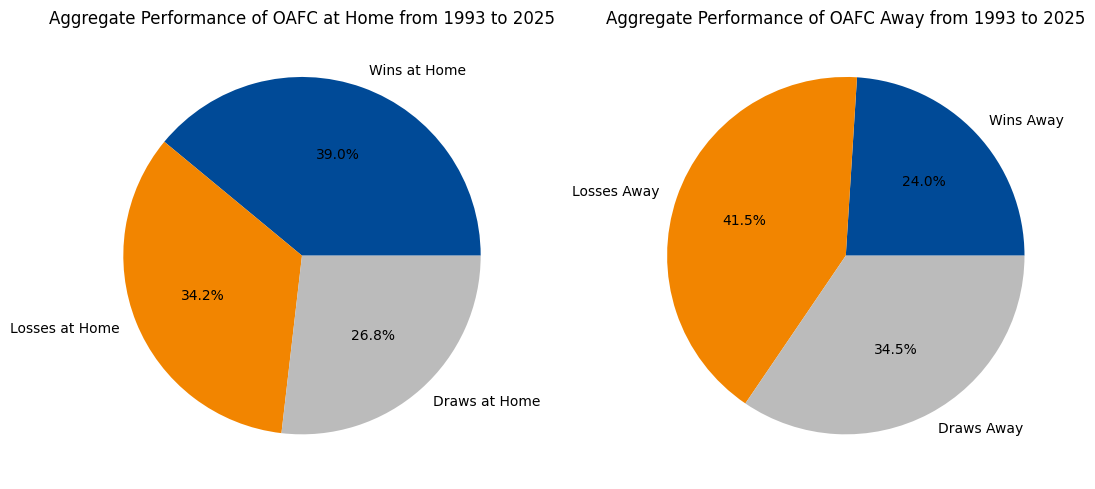

In [3]:
# Standardise Oldham naming just in case (optional safety step)
all_matches['HomeTeam'] = all_matches['HomeTeam'].str.strip()
all_matches['AwayTeam'] = all_matches['AwayTeam'].str.strip()

# Filter for Oldham games
oldham_home = all_matches[all_matches['HomeTeam'] == 'Oldham']
oldham_away = all_matches[all_matches['AwayTeam'] == 'Oldham']

home_match_dates = oldham_home['Date']
away_match_dates = oldham_away['Date']

# AGGREGATE ACROSS ALL DIVISIONS
home_win_all = oldham_home[oldham_home['FTR'] == 'H']
home_loss_all = oldham_home[oldham_home['FTR'] == 'A']
home_draw_all = oldham_home[oldham_home['FTR'] == 'D']

away_win_all = oldham_away[oldham_away['FTR'] == 'A']
away_loss_all = oldham_away[oldham_away['FTR'] == 'H']
away_draw_all = oldham_away[oldham_away['FTR'] == 'D']

home_team_all = np.array([len(home_win_all), len(home_loss_all), len(home_draw_all)])
away_team_all = np.array([len(away_win_all), len(away_loss_all), len(away_draw_all)])

# Plotting
home_labels = ['Wins at Home', 'Losses at Home', 'Draws at Home']
away_labels = ['Wins Away', 'Losses Away', 'Draws Away']
colours = ['#004A97', '#F28500', '#BBBBBB']

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(11,9 ))

axs[0].pie(home_team_all, labels=home_labels, colors=colours, autopct='%1.1f%%')
axs[0].set_title('Aggregate Performance of OAFC at Home from 1993 to 2025')

axs[1].pie(away_team_all, labels=away_labels, colors=colours, autopct='%1.1f%%')
axs[1].set_title('Aggregate Performance of OAFC Away from 1993 to 2025')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


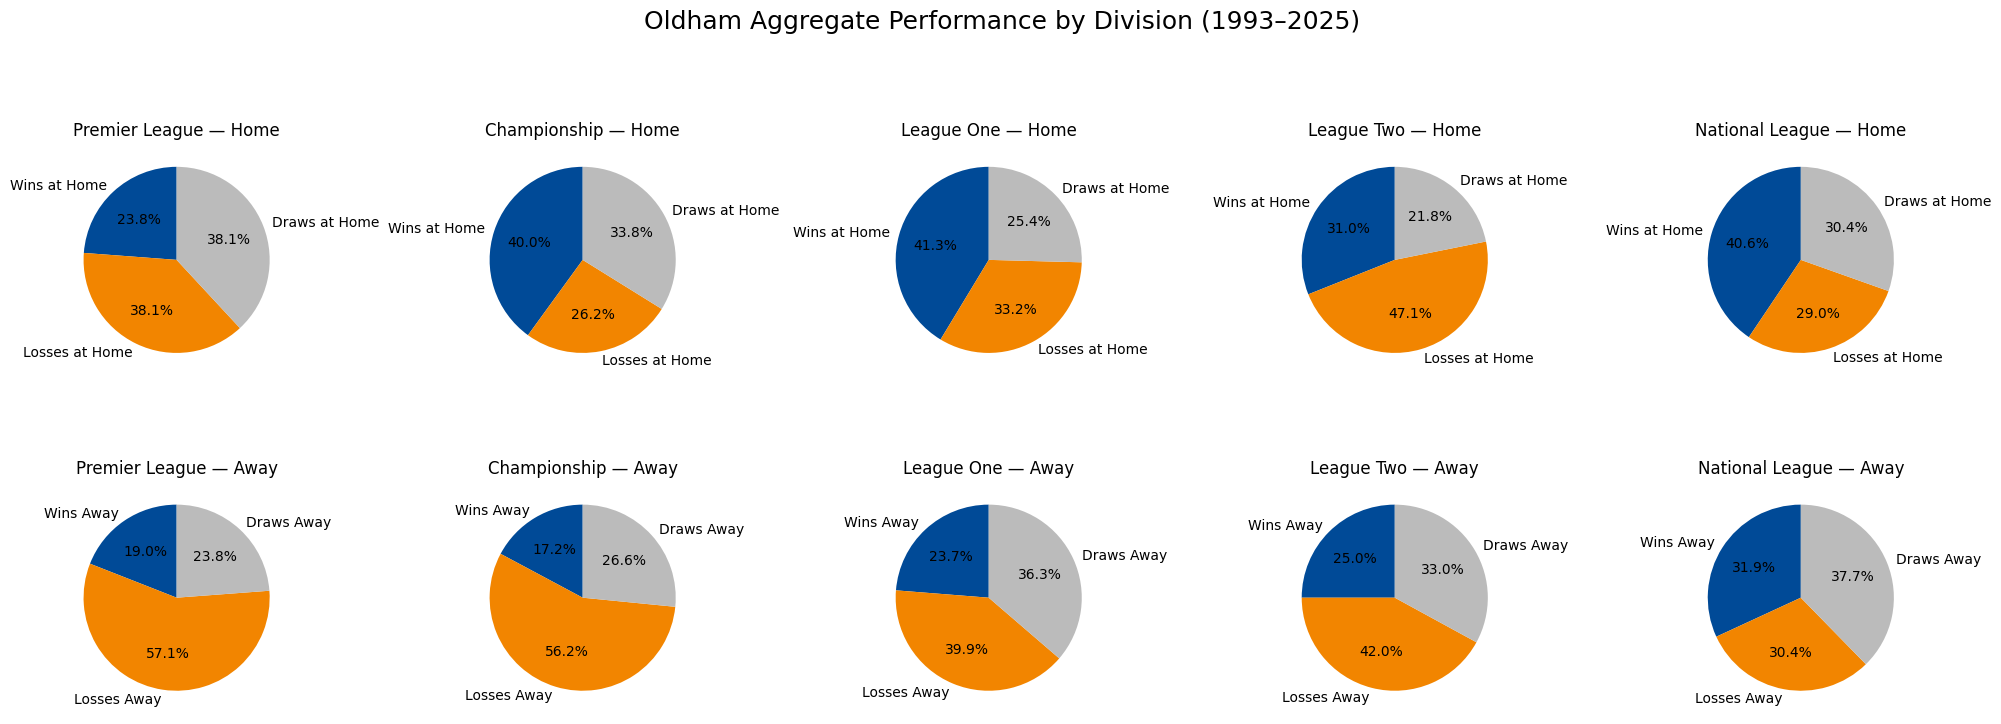

In [4]:
# Mapping of division codes to league names
division_names = {
    'E0': 'Premier League',
    'E1': 'Championship',
    'E2': 'League One',
    'E3': 'League Two',
    'EC': 'National League'
}

# Standardise Oldham naming
all_matches['HomeTeam'] = all_matches['HomeTeam'].str.strip()
all_matches['AwayTeam'] = all_matches['AwayTeam'].str.strip()

oldham_home = all_matches[all_matches['HomeTeam'] == 'Oldham']
oldham_away = all_matches[all_matches['AwayTeam'] == 'Oldham']

# Remove NaNs, convert to string, and sort divisions
tiers = sorted(all_matches['Div'].dropna().astype(str).unique())
n_divs = len(tiers)

# Pie chart settings
colours = ['#004A97', '#F28500', '#BBBBBB']  # Wins, Losses, Draws - Latics colours
home_labels = ['Wins at Home', 'Losses at Home', 'Draws at Home']
away_labels = ['Wins Away', 'Losses Away', 'Draws Away']

# Set up 2 rows (home, away), and N columns (one per division)
fig, axs = plt.subplots(nrows=2, ncols=n_divs, figsize=(4 * n_divs, 8))
fig.suptitle('Oldham Aggregate Performance by Division (1993–2025)', fontsize=18)

# If only one division, axs is 1D, so make it 2D
if n_divs == 1:
    axs = np.expand_dims(axs, axis=1)

for i, tier in enumerate(tiers):
    home_tier = oldham_home[oldham_home['Div'] == tier]
    away_tier = oldham_away[oldham_away['Div'] == tier]

    home_win = len(home_tier[home_tier['FTR'] == 'H'])
    home_loss = len(home_tier[home_tier['FTR'] == 'A'])
    home_draw = len(home_tier[home_tier['FTR'] == 'D'])
    home_counts = np.array([home_win, home_loss, home_draw])

    away_win = len(away_tier[away_tier['FTR'] == 'A'])
    away_loss = len(away_tier[away_tier['FTR'] == 'H'])
    away_draw = len(away_tier[away_tier['FTR'] == 'D'])
    away_counts = np.array([away_win, away_loss, away_draw])

    home_title = f"{division_names.get(tier, tier)} — Home"
    away_title = f"{division_names.get(tier, tier)} — Away"

    axs[0, i].pie(home_counts, labels=home_labels, colors=colours, autopct='%1.1f%%', startangle=90)
    axs[0, i].set_title(home_title)

    axs[1, i].pie(away_counts, labels=away_labels, colors=colours, autopct='%1.1f%%', startangle=90)
    axs[1, i].set_title(away_title)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Weather Data

Now we load the weather dataset from
https://meteostat.net/en/. The data here is from Ringway, Manchester - about 15 miles away. Oldham town centre lies at about 200m above sea level surrounded by the Pennines, so we must apply a correction to account for this. For this experiment, I have chosen -2 degrees and +4 km/h to adjust for the geographic differences between Ringway and Oldham. On top of this, we will clean the data so that the date format aligns with that of the football dataset.



In [5]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/OAFC/'
file_pattern = os.path.join(folder_path, 'WeatherData_*.csv')

files = glob.glob(file_pattern)
print("Files found:", files)

dfs = []
for file in files:
    df = pd.read_csv(file, index_col=0)  # or adjust parameters as needed
    dfs.append(df)

weather = pd.concat(dfs, ignore_index=False)
print(f"Combined DataFrame shape: {weather.shape}")

display(weather.head())
display(weather.shape)

Files found: ['/content/drive/MyDrive/Colab Notebooks/OAFC/WeatherData_19932000.csv', '/content/drive/MyDrive/Colab Notebooks/OAFC/WeatherData_20012009.csv', '/content/drive/MyDrive/Colab Notebooks/OAFC/WeatherData_20102015.csv', '/content/drive/MyDrive/Colab Notebooks/OAFC/WeatherData_20162025.csv']
Combined DataFrame shape: (11869, 10)


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
date,,,,,,,,,,
1993-01-01 00:00:00,2.2,NaN,5.1,NaN,NaN,NaN,14.1,NaN,1033.1,NaN
1993-01-02 00:00:00,-0.3,-3.8,2.3,0.0,NaN,NaN,13.4,NaN,1032.8,NaN
1993-01-03 00:00:00,-2.3,-7.5,1.4,0.0,NaN,NaN,19.7,NaN,1027.2,NaN
1993-01-04 00:00:00,2.3,0.3,4.7,NaN,NaN,NaN,21.4,NaN,1020.0,NaN
1993-01-05 00:00:00,6.9,1.6,10.1,1.0,NaN,NaN,21.8,NaN,1016.2,NaN


(11869, 10)

In [6]:
# Parse dates in all_matches, letting pandas infer two-digit years
all_matches['Date'] = pd.to_datetime(all_matches['Date'], dayfirst=True, errors='coerce')

# Similarly parse weather dates (assuming 'date' column is string or datetime)
weather = weather.reset_index()
weather.rename(columns={'date': 'Date'}, inplace=True)
weather['Date'] = pd.to_datetime(weather['Date'], dayfirst=True, errors='coerce')

# Filter for Oldham matches
oldham_home = all_matches[all_matches['HomeTeam'] == 'Oldham']
#oldham_away = all_matches[all_matches['AwayTeam'] == 'Oldham']
oldham_match_dates = (oldham_away['Date']).dropna().unique()

# Filter weather to only those dates
match_weather = weather[weather['Date'].isin(oldham_match_dates)]

# Apply Oldham-specific adjustments
match_weather['tavg_oldham'] = match_weather['tavg'] - 2  # temperature in °C
match_weather['wspd_oldham'] = match_weather['wspd'] + 4  # wind speed in km/h

# Convert date to string for output if needed
match_weather['Date_str'] = match_weather['Date'].dt.strftime('%d/%m/%Y')


/tmp/ipython-input-6-1255083004.py:15: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  match_weather = weather[weather['Date'].isin(oldham_match_dates)]
/tmp/ipython-input-6-1255083004.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_weather['tavg_oldham'] = match_weather['tavg'] - 2  # temperature in °C
/tmp/ipython-input-6-1255083004.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

## Calculating the Win Rate
Then we will obtain the win rate for Oldham.

In [7]:
# Filter Oldham matches
oldham_home = all_matches[all_matches['HomeTeam'] == 'Oldham'].copy()
oldham_home['OldhamSide'] = 'Home'

#oldham_away = all_matches[all_matches['AwayTeam'] == 'Oldham'].copy()
#oldham_away['OldhamSide'] = 'Away'

# Combine
oldham_matches = oldham_home

# Ensure datetime format and normalized (no time component)
oldham_matches['Date'] = pd.to_datetime(oldham_matches['Date'], dayfirst=True).dt.normalize()
weather['Date'] = pd.to_datetime(weather['Date'], dayfirst=True).dt.normalize()

# Optional: select only needed columns for performance
oldham_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTR', 'OldhamSide']
weather_cols = ['Date', 'tavg', 'wspd', 'pres']

oldham_matches = oldham_matches[oldham_cols]
weather = weather[weather_cols]

# Merge on Date
matches_with_weather = pd.merge(oldham_matches, weather, on='Date', how='inner')

# Vectorised Oldham win calculation
home_win = (matches_with_weather['OldhamSide'] == 'Home') & (matches_with_weather['FTR'] == 'H')
away_win = (matches_with_weather['OldhamSide'] == 'Away') & (matches_with_weather['FTR'] == 'A')

matches_with_weather['OldhamWin'] = 0
matches_with_weather.loc[home_win | away_win, 'OldhamWin'] = 1


## Does better weather mean better results?

From here we can calculate the correlation between weather metrics and Oldham's win rates. We first begin with a simple correlation calculation across the three variables.

In [8]:
# Correlation between temperature and Oldham win
correlation = matches_with_weather[['tavg', 'OldhamWin']].corr()
print("Correlation between average temperature and Oldham win:")
print(correlation)

# Correlation between Wind Speed and Oldham win
correlation = matches_with_weather[['wspd', 'OldhamWin']].corr()
print("Correlation between Wind Speed and Oldham win:")
print(correlation)

# Correlation between Pressure and Oldham win
correlation = matches_with_weather[['pres', 'OldhamWin']].corr()
print("Correlation between Pressure and Oldham win:")
print(correlation)

Correlation between average temperature and Oldham win:
                   tavg     OldhamWin
tavg       1.000000e+00  7.729946e-07
OldhamWin  7.729946e-07  1.000000e+00
Correlation between Wind Speed and Oldham win:
               wspd  OldhamWin
wspd       1.000000   0.000006
OldhamWin  0.000006   1.000000
Correlation between Pressure and Oldham win:
                   pres     OldhamWin
pres       1.000000e+00 -2.534381e-07
OldhamWin -2.534381e-07  1.000000e+00


So this implies no linear correlation between temp and performance.

## Is Oldham better playing away or at home in harsh weather?
 We can compare whether Oldham performs better under low temps depending on the venue by calculating the correlation between a low temp threshold and home vs away.

In [9]:
# Define thresholds
cold_temp_threshold = 7
strong_wind_threshold = 20

# Create indicator columns
matches_with_weather['ColdWeather'] = (matches_with_weather['tavg'] < cold_temp_threshold).astype(int)
matches_with_weather['StrongWind'] = (matches_with_weather['wspd'] > strong_wind_threshold).astype(int)

# Separate home and away games
home_games = matches_with_weather[matches_with_weather['OldhamSide'] == 'Home']
#away_games = matches_with_weather[matches_with_weather['OldhamSide'] == 'Away']

# Correlations for home games
corr_cold_home = home_games[['ColdWeather', 'OldhamWin']].corr().loc['ColdWeather', 'OldhamWin']
corr_wind_home = home_games[['StrongWind', 'OldhamWin']].corr().loc['StrongWind', 'OldhamWin']

print(f"Home games: Correlation between Cold Weather (<7°C) and Oldham Win: {corr_cold_home:.10f}")
print(f"Home games: Correlation between Strong Wind (>20 km/h) and Oldham Win: {corr_wind_home:.10f}")

# Correlations for away games
#corr_cold_away = away_games[['ColdWeather', 'OldhamWin']].corr().loc['ColdWeather', 'OldhamWin']
#corr_wind_away = away_games[['StrongWind', 'OldhamWin']].corr().loc['StrongWind', 'OldhamWin']

#print(f"Away games: Correlation between Cold Weather (<7°C) and Oldham Win: {corr_cold_away:.10f}")
#print(f"Away games: Correlation between Strong Wind (>20 km/h) and Oldham Win: {corr_wind_away:.10f}")


Home games: Correlation between Cold Weather (<7°C) and Oldham Win: -0.0000023119
Home games: Correlation between Strong Wind (>20 km/h) and Oldham Win: 0.0000043756


There is no correlation between the two variables.

## Applying ML
 To confirm that Oldham is unaffected by weather, we can complicate the model by introducing machine learning. In essence, we will ask the machine to predict Oldham's win/loss based on temp, wind speeds and pressure. Here we will use Random Forest and XGBoost.

**Random Forest** </br> Random Forest operates by constructing a large number of decision trees during training, each trained on a randomly sampled subset of the data with replacement (bootstrap sampling), and with random feature selection at each split. The final prediction is obtained via majority voting (in classification) or averaging (in regression). This randomisation introduces diversity among the trees, which helps reduce variance and mitigate overfitting — a common issue with single decision trees. It is generally robust to noise and performs well out-of-the-box without extensive hyperparameter tuning.

**XGBoost (Extreme Gradient Boosting)** </br> On the other hand, XGBoost implements a form of gradient-boosted decision trees. Rather than building trees independently, XGBoost builds them sequentially, with each new tree trained to predict the residual errors (gradients) of the previous ensemble. This iterative optimisation makes XGBoost highly effective at capturing complex patterns in the data. Additionally, XGBoost includes several regularisation techniques, such as shrinkage and L1/L2 penalties, which help prevent overfitting while maintaining strong predictive performance.

In the context of our analysis, both models are used to evaluate whether weather features have any predictive power over Oldham’s match outcomes.

Class Weights: {np.int64(0): np.float64(0.8377319695855472), np.int64(1): np.float64(1.2402319665111694)}
Random Forest Accuracy: 0.481786398722048
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.47      0.52    471520
           1       0.39      0.50      0.44    318494

    accuracy                           0.48    790014
   macro avg       0.49      0.49      0.48    790014
weighted avg       0.50      0.48      0.49    790014

Confusion Matrix:
 [[220688 250832]
 [158564 159930]]


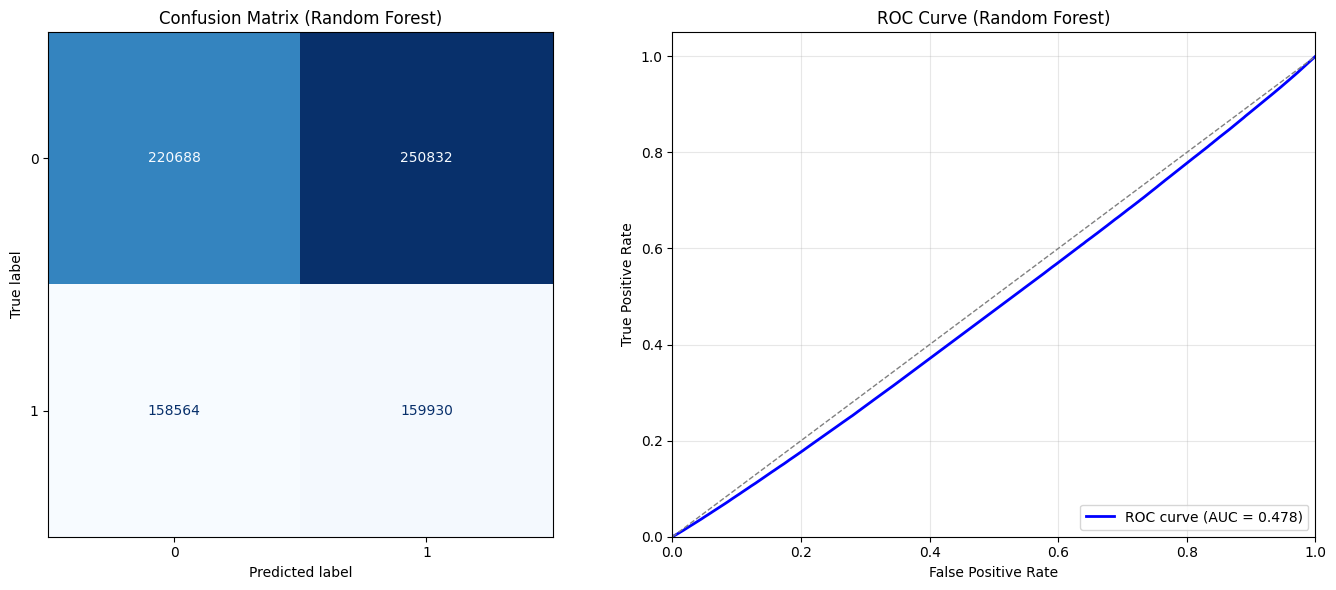

In [10]:


# Select features to target
features = ['tavg', 'wspd', 'pres']
X = matches_with_weather[features]
y = matches_with_weather['OldhamWin']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)


# Training
X_sample, _, y_sample, _ = train_test_split(
    X_imputed, y, train_size=0.99, stratify=y, random_state=42
)
classes = np.unique(y_sample)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_sample)
class_weights = dict(zip(classes, weights))
print("Class Weights:", class_weights)

X_train, X_test, y_train, y_test = train_test_split(
    X_sample, y_sample, stratify=y_sample, random_state=42
)

# Define Random Forest model
model_rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    class_weight=class_weights,
    n_jobs=-1,
    random_state=42
)

# Fit model
model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = model_rf.predict(X_test)

# Evaluation
print("Random Forest Accuracy:", model_rf.score(X_test, y_test))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Plot confusion matrix and ROC curve side-by-side
cm = confusion_matrix(y_test, y_pred_rf)
fpr, tpr, _ = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
disp.plot(cmap=plt.cm.Blues, ax=axs[0], colorbar=False)
axs[0].set_title('Confusion Matrix (Random Forest)')

# ROC Curve
axs[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axs[1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve (Random Forest)')
axs[1].legend(loc='lower right')
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


XGBoost:

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:36:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost accuracy: 0.40314981759816915
XGBoost Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    471520
           1       0.40      1.00      0.57    318494

    accuracy                           0.40    790014
   macro avg       0.20      0.50      0.29    790014
weighted avg       0.16      0.40      0.23    790014



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


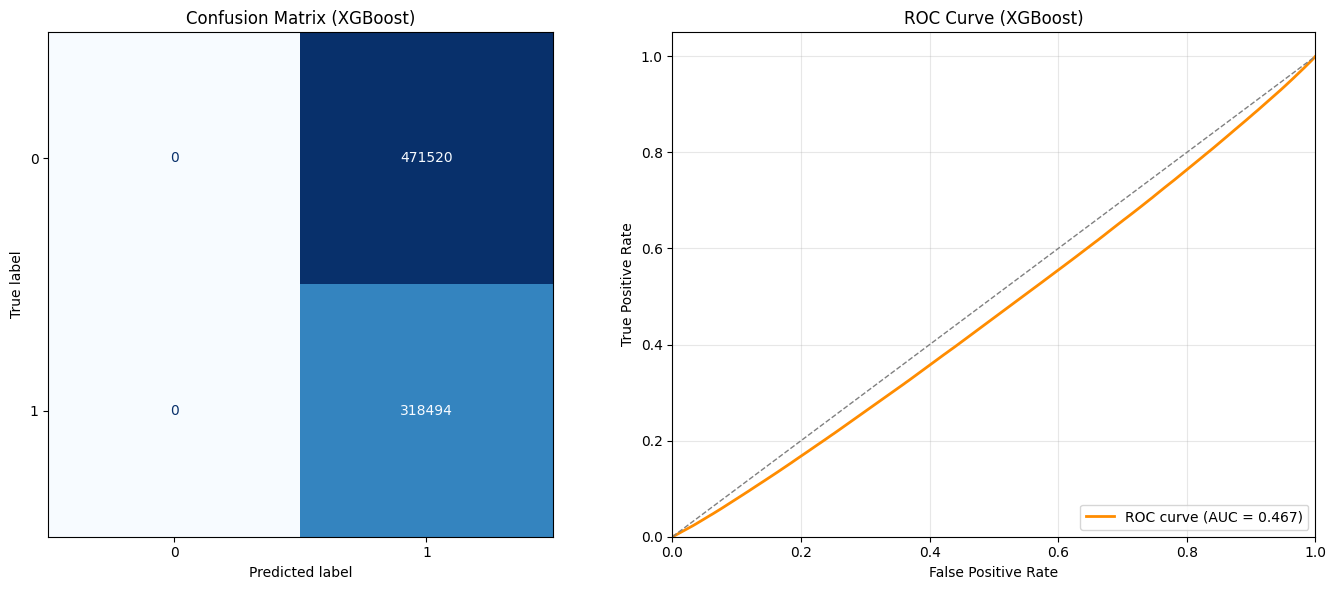

In [11]:
scale_pos_weight = 3245463 / 1489275

model_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

# Train model
model_xgb.fit(X_train, y_train)

# Evaluate
print("XGBoost accuracy:", model_xgb.score(X_test, y_test))

y_pred_xgb = model_xgb.predict(X_test)

print("XGBoost Classification Report")
print(classification_report(y_test, y_pred_xgb))

# Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# ROC data
y_prob_xgb = model_xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Confusion Matrix
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=model_xgb.classes_)
disp_xgb.plot(cmap=plt.cm.Blues, ax=axs[0], colorbar=False)
axs[0].set_title('Confusion Matrix (XGBoost)')

# ROC Curve
axs[1].plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_xgb:.3f})')
axs[1].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Random baseline
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve (XGBoost)')
axs[1].legend(loc='lower right')
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


From this, we can see that both the Random Forst and XGBoost exhibit poor predictive performances on test data. THis is from the confusion matrices having a significant amount of false positives and negatives, showing a high misclassification. Both models have ROC AUC scores of nearly 0.5, showing that the model is essentially guessing. This points towards no power to separate between the two classes, implying that there is no correlation - linear or otherwise - between the weather and Oldham's performance.

## Discussion - Limitations and Future Improvements
Unfortunately, there are no weather stations located directly at Boundary Park, so we used data from Manchester Airport as the closest available proxy. This approximation is less accurate for away matches, as weather conditions vary between locations. Although we applied a uniform correction to estimate Oldham’s local weather, it does not fully capture these spatial differences.

To increase the holisticness of this study, it would be optimal to consider other weather related metrics eg precipitation, time of day etc. to more specific football metrics such as goal differences or shots on target. This would let us probe deeper into the correlations (or a lack of) within football and weather. I would also consider expanding this to an interactive programme that requests the user for a team of interest, pick a location see if there are more teams affected by more advanced metrics.

## Conclusion
Despite these limitations, our analysis indicates that Oldham’s performance is not influenced by weather conditions. Correlation metrics showed no significant relationships between weather variables and match outcomes. Additionally, machine learning models reflected the largely unpredictable nature of game results, even when weather factors were included.

